# 5.4 SAGANの作成

- 本ファイルでは、Self-Attention GANのネットワークを実装と学習をします。


# 5.4 学習目標

1.	SAGANを実装できるようになる


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Self-Attentionモジュールの実装

In [3]:
class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N

        # かけ算
        S = torch.bmm(proj_query, proj_key)  # bmmはバッチごとの行列かけ算です

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


# Generatorの実装

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attentin層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attentin層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 3, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

        self.self_attntion2 = Self_Attention(in_dim=64)

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


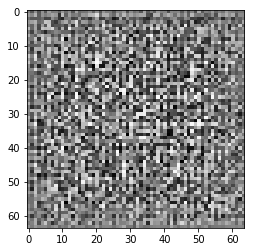

In [5]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=128, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 128)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [6]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(3, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))

        # Self-Attentin層を追加
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(0.3))

        # Self-Attentin層を追加
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


In [7]:
# 動作確認
D = Discriminator(z_dim=128, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 128)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# 偽画像をDに入力
d_out, attention_map1, attention_map2 = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.5059]]]], grad_fn=<SigmoidBackward>)


# DataLoaderの作成

In [8]:
from functools import partial
from multiprocessing import Pool
import os
from pathlib import Path
import random
import shutil
import time
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import truncnorm
import torch
from torch import nn, optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image

In [9]:
start_time = time.time()

batch_size = 64
epochs = 300
seed = 1029

TRAIN_DIR = Path('../input/all-dogs/')
ANNOTATION_DIR = Path('../input/annotation/Annotation/')
DOG_DIR = Path('../dogs/dogs/')
OUT_DIR = Path('../output_images/')
DOG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

device = torch.device('cuda')

lr = 1e-3
beta1 = 0.9
nz = 128

real_label = 0.9
fake_label = 0.0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [10]:
class DogsDataset(Dataset):
    
    def __init__(self, root, annotation_root, transform=None,
                 target_transform=None, loader=default_loader, n_process=4):
        self.root = Path(root)
        self.annotation_root = Path(annotation_root)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.imgs = self.cut_out_dogs(n_process)

    def _get_annotation_path(self, img_path):
        dog = Path(img_path).stem
        breed = dog.split('_')[0]
        breed_dir = next(self.annotation_root.glob(f'{breed}-*'))
        return breed_dir / dog
    
    @staticmethod
    def _get_dog_box(annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            yield (xmin, ymin, xmax, ymax)
            
    def crop_dog(self, path):
        imgs = []
        annotation_path = self._get_annotation_path(path)
        for bndbox in self._get_dog_box(annotation_path):
            img = self.loader(path)
            img_ = img.crop(bndbox)
            if np.sum(img_) != 0:
                img = img_
            imgs.append(img)
        return imgs
                
    def cut_out_dogs(self, n_process):
        with Pool(n_process) as p:
            imgs = p.map(self.crop_dog, self.root.iterdir())
        return imgs
    
    def __getitem__(self, index):
        samples = random.choice(self.imgs[index])
        if self.transform is not None:
            samples = self.transform(samples)
        return samples
    
    def __len__(self):
        return len(self.imgs)

In [11]:
class ParamScheduler(object):
    
    def __init__(self, optimizer, scale_fn, step_size):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        self.scale_fn = scale_fn
        self.step_size = step_size
        self.last_batch_iteration = 0
        
    def batch_step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scale_fn(self.last_batch_iteration / self.step_size)
        
        self.last_batch_iteration += 1


def combine_scale_functions(scale_fns, phases=None):
    if phases is None:
        phases = [1. / len(scale_fns)] * len(scale_fns)
    phases = [phase / sum(phases) for phase in phases]
    phases = torch.tensor([0] + phases)
    phases = torch.cumsum(phases, 0)
    
    def _inner(x):
        idx = (x >= phases).nonzero().max()
        actual_x = (x - phases[idx]) / (phases[idx + 1] - phases[idx])
        return scale_fns[idx](actual_x)
        
    return _inner


def scale_cos(start, end, x):
    return start + (1 + np.cos(np.pi * (1 - x))) * (end - start) / 2

In [12]:
random_transforms = [transforms.RandomRotation(degrees=1)] # 1度の回転
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.1),
                                transforms.RandomApply(random_transforms, p=0.01),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogsDataset(TRAIN_DIR / 'all-dogs/', ANNOTATION_DIR, transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

# 学習させる

In [13]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義 → hinge version of the adversarial lossに変更
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 128
    mini_batch_size = batch_size

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    d_loss_log = []
    g_loss_log = []
    dout_real_log = []
    dout_fake_log = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和
        epoch_dout_real = 0.0
        epoch_dout_fake = 0.0

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 誤差を計算→hinge version of the adversarial lossに変更
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 誤差　d_out_realが1以上で誤差0になる。d_out_real>1で、
            # 1.0 - d_out_realが負の場合ReLUで0にする

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 誤差　d_out_fakeが-1以下なら誤差0になる。d_out_fake<-1で、
            # 1.0 + d_out_realが負の場合ReLUで0にする

            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 誤差を計算→hinge version of the adversarial lossに変更
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake.mean()

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_dout_real += d_loss_real.item()
            epoch_dout_fake += d_loss_fake.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||dout_r:{:.4f},dout_f:{:.4f}'.format(
            epoch, epoch_d_loss/batch, epoch_g_loss/batch, epoch_dout_real/batch, epoch_dout_fake/batch))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        d_loss_log.append(epoch_d_loss/batch)
        g_loss_log.append(epoch_g_loss/batch)
        dout_real_log.append(epoch_dout_real/batch)
        dout_fake_log.append(epoch_dout_fake/batch)
        
        if epoch % 30 == 0:
            # 生成画像と訓練データを可視化する
            # 本セルは、良い感じの画像が生成されるまで、何度か実行をし直しています

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # 入力の乱数生成
            sample_batch_size = 8
            z_dim = 128
            fixed_z = torch.randn(sample_batch_size, z_dim)
            fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

            # 画像生成
            fake_images, am1, am2 = G(fixed_z.to(device))
            fake_images = fake_images.cpu().detach().numpy().transpose(0, 2, 3, 1)

            # 訓練データ
            batch_iterator = iter(train_loader)  # イテレータに変換
            imges = next(batch_iterator)  # 1番目の要素を取り出す
            imges = imges.cpu().detach().numpy().transpose(0, 2, 3, 1)


            # 出力
            fig = plt.figure(figsize=(15, 6))
            for i in range(0, 5):
                # 上段に訓練データを
                plt.subplot(2, 5, i+1)
                plt.imshow(imges[i])

                # 下段に生成データを表示する
                plt.subplot(2, 5, 5+i+1)
                plt.imshow(fake_images[i])
            plt.show()

    # print("総イテレーション回数:", iteration)

    return G, D, d_loss_log, g_loss_log, dout_real_log, dout_fake_log


In [14]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:5.5222 ||Epoch_G_Loss:5.2379 ||dout_r:3.2908,dout_f:2.2314
timer:  50.0389 sec.


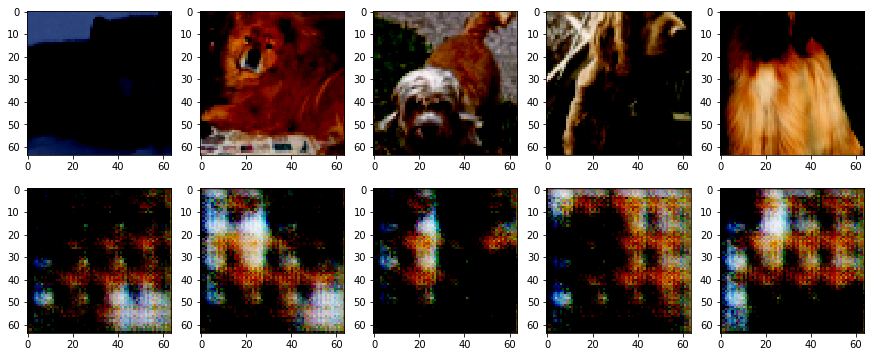

-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:9.2475 ||Epoch_G_Loss:2.4909 ||dout_r:5.1747,dout_f:4.0728
timer:  49.1414 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:8.1651 ||Epoch_G_Loss:3.3008 ||dout_r:4.4452,dout_f:3.7199
timer:  49.1189 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:8.0189 ||Epoch_G_Loss:3.2566 ||dout_r:4.2617,dout_f:3.7572
timer:  49.4344 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:7.3612 ||Epoch_G_Loss:3.7702 ||dout_r:3.9915,dout_f:3.3697
timer:  50.1476 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:6.5825 ||Epoch_G_Loss:3.8896 ||dout_r:3.5526,dout_f:3.0300
timer:  50.0369 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:5.7244 ||Epoch_G_Loss:4.5394 ||dout_r:3.1126,dout_f:2.6118
timer:  49.7145 sec.
----

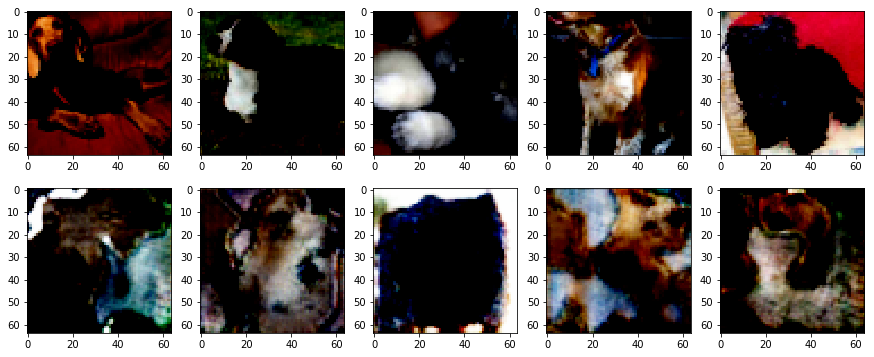

-------------
Epoch 31/300
-------------
（train）
-------------
epoch 31 || Epoch_D_Loss:4.6742 ||Epoch_G_Loss:5.3507 ||dout_r:2.5547,dout_f:2.1195
timer:  48.9395 sec.
-------------
Epoch 32/300
-------------
（train）
-------------
epoch 32 || Epoch_D_Loss:4.5730 ||Epoch_G_Loss:5.5479 ||dout_r:2.5470,dout_f:2.0260
timer:  48.9000 sec.
-------------
Epoch 33/300
-------------
（train）
-------------
epoch 33 || Epoch_D_Loss:4.6099 ||Epoch_G_Loss:5.4472 ||dout_r:2.5637,dout_f:2.0463
timer:  48.7666 sec.
-------------
Epoch 34/300
-------------
（train）
-------------
epoch 34 || Epoch_D_Loss:4.5680 ||Epoch_G_Loss:5.4010 ||dout_r:2.5073,dout_f:2.0607
timer:  48.6799 sec.
-------------
Epoch 35/300
-------------
（train）
-------------
epoch 35 || Epoch_D_Loss:4.5544 ||Epoch_G_Loss:5.4491 ||dout_r:2.4894,dout_f:2.0650
timer:  48.6563 sec.
-------------
Epoch 36/300
-------------
（train）
-------------
epoch 36 || Epoch_D_Loss:4.5256 ||Epoch_G_Loss:5.4994 ||dout_r:2.4728,dout_f:2.0528
timer:  48.95

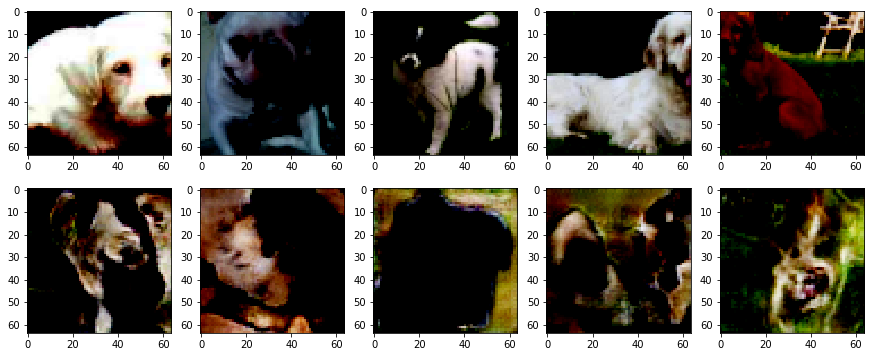

-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:4.5632 ||Epoch_G_Loss:5.2295 ||dout_r:2.4853,dout_f:2.0779
timer:  48.9181 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:4.5754 ||Epoch_G_Loss:5.3730 ||dout_r:2.5126,dout_f:2.0628
timer:  48.4434 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:4.5948 ||Epoch_G_Loss:5.2999 ||dout_r:2.5418,dout_f:2.0530
timer:  48.5356 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:4.6253 ||Epoch_G_Loss:5.3698 ||dout_r:2.5339,dout_f:2.0914
timer:  48.4755 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:4.6076 ||Epoch_G_Loss:5.3763 ||dout_r:2.4983,dout_f:2.1092
timer:  48.4086 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:4.5920 ||Epoch_G_Loss:5.3695 ||dout_r:2.5034,dout_f:2.0886
timer:  48.41

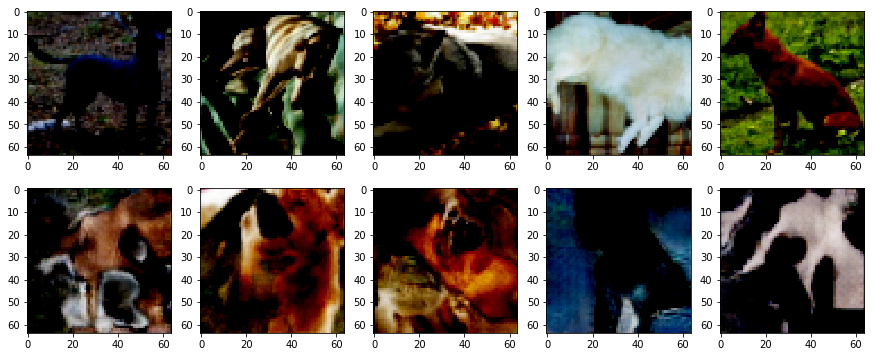

-------------
Epoch 91/300
-------------
（train）
-------------
epoch 91 || Epoch_D_Loss:4.7438 ||Epoch_G_Loss:4.9447 ||dout_r:2.5824,dout_f:2.1614
timer:  48.4743 sec.
-------------
Epoch 92/300
-------------
（train）
-------------
epoch 92 || Epoch_D_Loss:4.7405 ||Epoch_G_Loss:5.0267 ||dout_r:2.5936,dout_f:2.1469
timer:  48.8079 sec.
-------------
Epoch 93/300
-------------
（train）
-------------
epoch 93 || Epoch_D_Loss:4.7756 ||Epoch_G_Loss:5.0163 ||dout_r:2.6290,dout_f:2.1467
timer:  48.5931 sec.
-------------
Epoch 94/300
-------------
（train）
-------------
epoch 94 || Epoch_D_Loss:4.8445 ||Epoch_G_Loss:4.9126 ||dout_r:2.6270,dout_f:2.2175
timer:  48.4147 sec.
-------------
Epoch 95/300
-------------
（train）
-------------
epoch 95 || Epoch_D_Loss:4.7827 ||Epoch_G_Loss:5.0369 ||dout_r:2.6353,dout_f:2.1474
timer:  48.4619 sec.
-------------
Epoch 96/300
-------------
（train）
-------------
epoch 96 || Epoch_D_Loss:4.7923 ||Epoch_G_Loss:4.9960 ||dout_r:2.6011,dout_f:2.1912
timer:  48.43

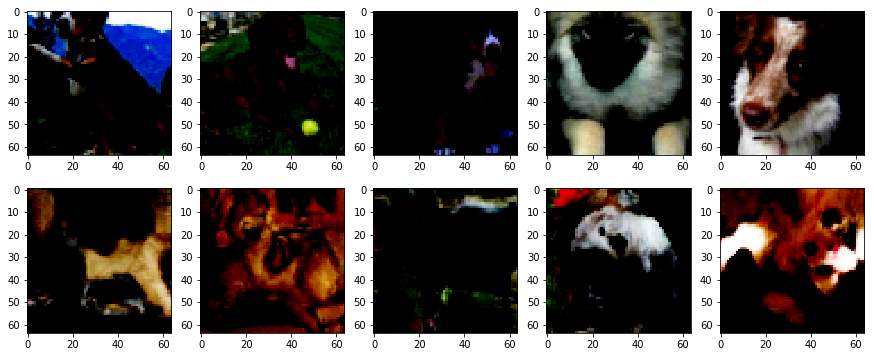

-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:4.7683 ||Epoch_G_Loss:4.9839 ||dout_r:2.5844,dout_f:2.1839
timer:  48.1923 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:4.7745 ||Epoch_G_Loss:5.0118 ||dout_r:2.6126,dout_f:2.1619
timer:  48.1764 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:4.7926 ||Epoch_G_Loss:4.9932 ||dout_r:2.5927,dout_f:2.1999
timer:  48.5731 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:4.8116 ||Epoch_G_Loss:5.0084 ||dout_r:2.6422,dout_f:2.1694
timer:  48.1349 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:4.7251 ||Epoch_G_Loss:4.9844 ||dout_r:2.5728,dout_f:2.1523
timer:  48.1544 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:4.8467 ||Epoch_G_Loss:5.0593 ||dout_r:2.6300,dout_f:2.2167
t

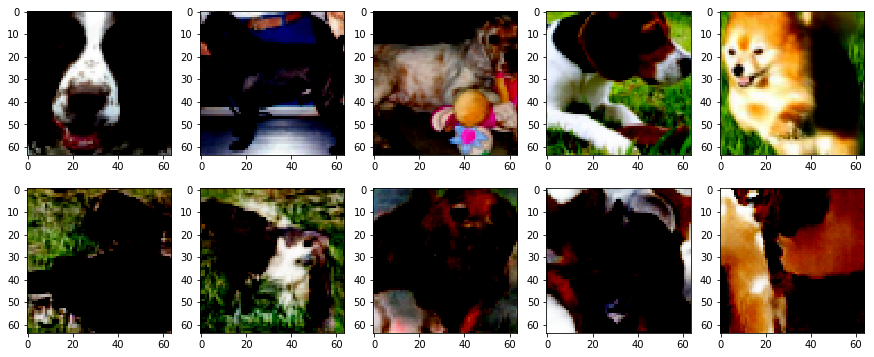

-------------
Epoch 151/300
-------------
（train）
-------------
epoch 151 || Epoch_D_Loss:4.7544 ||Epoch_G_Loss:5.0735 ||dout_r:2.5939,dout_f:2.1605
timer:  48.1684 sec.
-------------
Epoch 152/300
-------------
（train）
-------------
epoch 152 || Epoch_D_Loss:4.7820 ||Epoch_G_Loss:5.0127 ||dout_r:2.5949,dout_f:2.1871
timer:  47.9538 sec.
-------------
Epoch 153/300
-------------
（train）
-------------
epoch 153 || Epoch_D_Loss:4.7344 ||Epoch_G_Loss:5.1047 ||dout_r:2.6002,dout_f:2.1342
timer:  48.0832 sec.
-------------
Epoch 154/300
-------------
（train）
-------------
epoch 154 || Epoch_D_Loss:4.7563 ||Epoch_G_Loss:4.9951 ||dout_r:2.5908,dout_f:2.1654
timer:  48.0765 sec.
-------------
Epoch 155/300
-------------
（train）
-------------
epoch 155 || Epoch_D_Loss:4.7425 ||Epoch_G_Loss:5.0041 ||dout_r:2.5638,dout_f:2.1787
timer:  48.4486 sec.
-------------
Epoch 156/300
-------------
（train）
-------------
epoch 156 || Epoch_D_Loss:4.7476 ||Epoch_G_Loss:5.1319 ||dout_r:2.5600,dout_f:2.1877
t

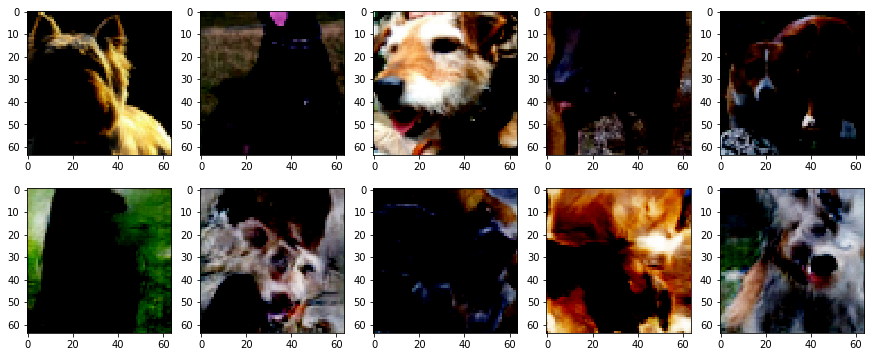

-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:4.7466 ||Epoch_G_Loss:5.1318 ||dout_r:2.5826,dout_f:2.1639
timer:  47.8314 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:4.7226 ||Epoch_G_Loss:5.1139 ||dout_r:2.5669,dout_f:2.1557
timer:  47.9416 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:4.7154 ||Epoch_G_Loss:5.0795 ||dout_r:2.5404,dout_f:2.1750
timer:  47.8839 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:4.7044 ||Epoch_G_Loss:5.1418 ||dout_r:2.5516,dout_f:2.1528
timer:  47.9216 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:4.6897 ||Epoch_G_Loss:5.0592 ||dout_r:2.5226,dout_f:2.1671
timer:  47.8624 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || Epoch_D_Loss:4.7320 ||Epoch_G_Loss:5.1013 ||dout_r:2.5712,dout_f:2.1608
t

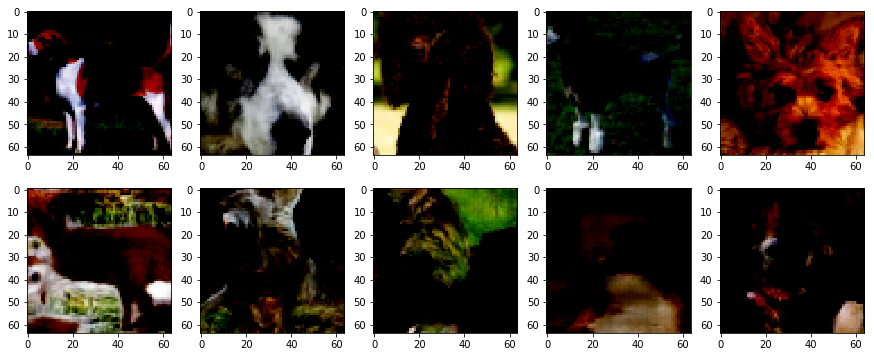

-------------
Epoch 211/300
-------------
（train）
-------------
epoch 211 || Epoch_D_Loss:4.6323 ||Epoch_G_Loss:5.2004 ||dout_r:2.5257,dout_f:2.1066
timer:  48.4079 sec.
-------------
Epoch 212/300
-------------
（train）
-------------
epoch 212 || Epoch_D_Loss:4.5931 ||Epoch_G_Loss:5.2262 ||dout_r:2.4738,dout_f:2.1193
timer:  48.0157 sec.
-------------
Epoch 213/300
-------------
（train）
-------------
epoch 213 || Epoch_D_Loss:4.6067 ||Epoch_G_Loss:5.1645 ||dout_r:2.5210,dout_f:2.0857
timer:  47.9667 sec.
-------------
Epoch 214/300
-------------
（train）
-------------
epoch 214 || Epoch_D_Loss:4.6635 ||Epoch_G_Loss:5.1514 ||dout_r:2.4977,dout_f:2.1658
timer:  47.9870 sec.
-------------
Epoch 215/300
-------------
（train）
-------------
epoch 215 || Epoch_D_Loss:4.5648 ||Epoch_G_Loss:5.1831 ||dout_r:2.4900,dout_f:2.0749
timer:  48.0024 sec.
-------------
Epoch 216/300
-------------
（train）
-------------
epoch 216 || Epoch_D_Loss:4.6017 ||Epoch_G_Loss:5.1778 ||dout_r:2.5127,dout_f:2.0890
t

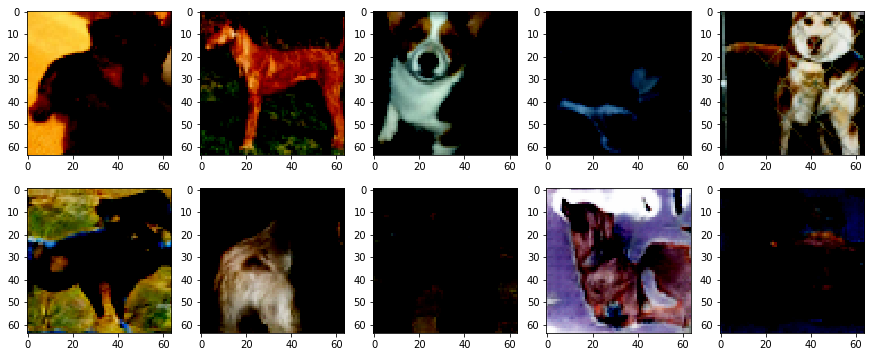

-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:4.5992 ||Epoch_G_Loss:5.2522 ||dout_r:2.4682,dout_f:2.1311
timer:  49.2779 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:4.5475 ||Epoch_G_Loss:5.3479 ||dout_r:2.4696,dout_f:2.0779
timer:  49.4133 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:4.5144 ||Epoch_G_Loss:5.3630 ||dout_r:2.4404,dout_f:2.0740
timer:  49.8828 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:4.5846 ||Epoch_G_Loss:5.3037 ||dout_r:2.4935,dout_f:2.0911
timer:  49.3375 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || Epoch_D_Loss:4.5497 ||Epoch_G_Loss:5.3809 ||dout_r:2.4622,dout_f:2.0875
timer:  49.3753 sec.
-------------
Epoch 246/300
-------------
（train）
-------------
epoch 246 || Epoch_D_Loss:4.5063 ||Epoch_G_Loss:5.2189 ||dout_r:2.4200,dout_f:2.0863
t

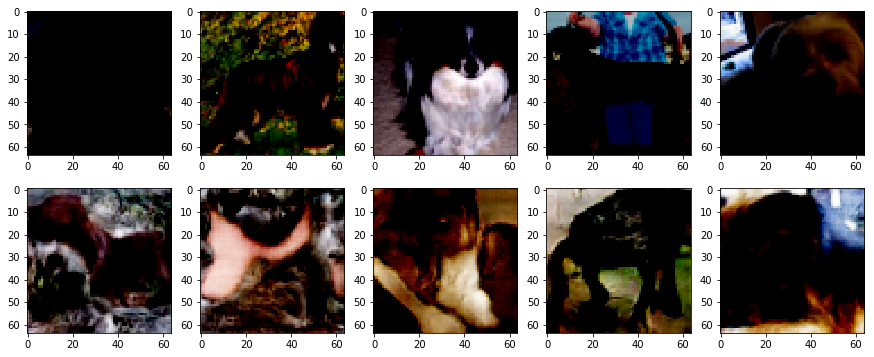

-------------
Epoch 271/300
-------------
（train）
-------------
epoch 271 || Epoch_D_Loss:4.4216 ||Epoch_G_Loss:5.4517 ||dout_r:2.3759,dout_f:2.0457
timer:  49.3514 sec.
-------------
Epoch 272/300
-------------
（train）
-------------
epoch 272 || Epoch_D_Loss:4.4309 ||Epoch_G_Loss:5.4042 ||dout_r:2.4070,dout_f:2.0239
timer:  49.3804 sec.
-------------
Epoch 273/300
-------------
（train）
-------------
epoch 273 || Epoch_D_Loss:4.4801 ||Epoch_G_Loss:5.3981 ||dout_r:2.4128,dout_f:2.0673
timer:  49.8005 sec.
-------------
Epoch 274/300
-------------
（train）
-------------
epoch 274 || Epoch_D_Loss:4.4264 ||Epoch_G_Loss:5.5913 ||dout_r:2.3923,dout_f:2.0341
timer:  49.5701 sec.
-------------
Epoch 275/300
-------------
（train）
-------------
epoch 275 || Epoch_D_Loss:4.4436 ||Epoch_G_Loss:5.4821 ||dout_r:2.4183,dout_f:2.0253
timer:  49.4605 sec.
-------------
Epoch 276/300
-------------
（train）
-------------
epoch 276 || Epoch_D_Loss:4.4881 ||Epoch_G_Loss:5.4358 ||dout_r:2.4213,dout_f:2.0667
t

In [15]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 300
G_update, D_update, d_loss_log, g_loss_log, dout_real_log, dout_fake_log = train_model(
    G, D, dataloader=train_loader, num_epochs=num_epochs)


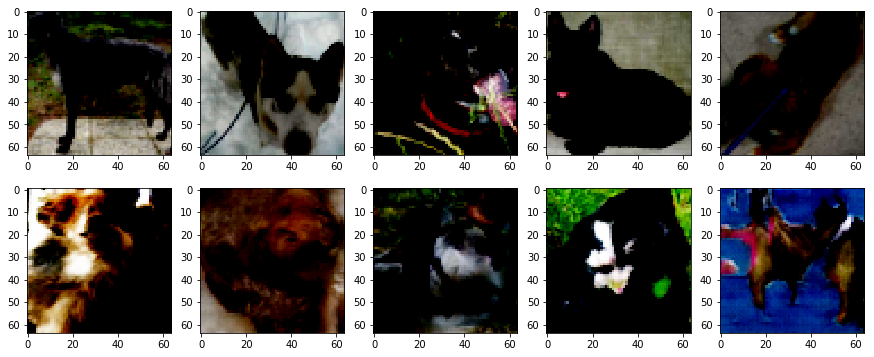

In [16]:
# 生成画像と訓練データを可視化する
# 本セルは、良い感じの画像が生成されるまで、何度か実行をし直しています

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 128
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_loader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i].cpu().detach().numpy().transpose(1, 2, 0))

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i].cpu().detach().numpy().transpose(1, 2, 0))


In [17]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 64
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    #gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images,_,_ = G_update(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

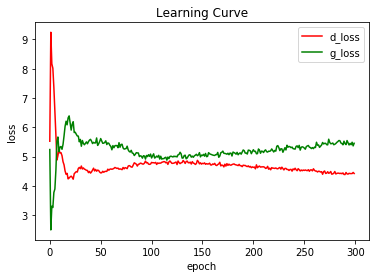

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()


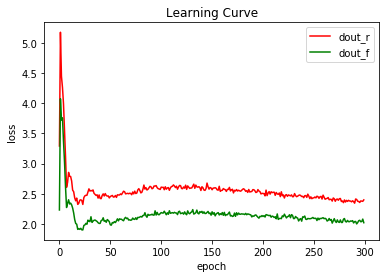

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()


以上